<a href="https://colab.research.google.com/github/obov/mnist/blob/main/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Chapter 1 - 1 심화과제

- 본 파일은 overfitting을 해결해보기 위해 CNN을 적용한 코드 및 로그가 남아 있는 파일입니다.
- 과제를 위한 파일은 [여기](https://github.com/hanghae-plus-AI/AI-1-obov/blob/5e32b8830948f1644dafa75d423fa6b07db09912/CIFAR10.ipynb)에서 확인 하실 수 있습니다.


In [1]:
"""
HYPER PARAMETERS
"""

LEARNING_RATE = 0.01
NUMBER_OF_EPOCHS = 50
BATCH_SIZE = 256
DATA_SET_NAME = "CIFAR10"
ACTIVATION_FUNCTION = "LeakyReLU"

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.ToTensor()

trainset = getattr(torchvision.datasets, DATA_SET_NAME)(
    root="./data", train=True, download=True, transform=transform
)

Files already downloaded and verified


50000
torch.Size([3, 32, 32]) 6


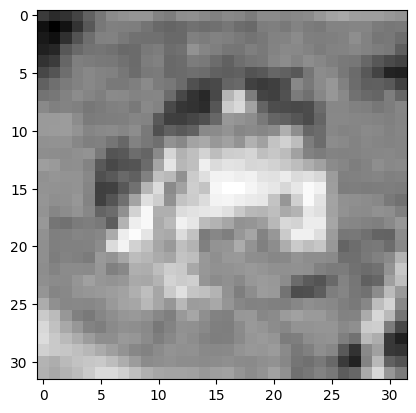

In [4]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap="gray")

In [5]:
from torch.utils.data import Subset


batch_size = BATCH_SIZE
# 0부터 47999까지는 훈련용, 48000부터 59999까지는 검증용으로 설정
train_indices = list(range(40000))
val_indices = list(range(40000, 50000))

train_dataset = Subset(trainset, train_indices)
val_dataset = Subset(trainset, val_indices)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [7]:
from torch import nn

output_dim = 10


class Model(nn.Module):
    def __init__(
        self,
        input_dim,
        n_dim,
        output_dim,
        activation_function="LeakyReLU",
        dropout_prob=0.0,
    ):
        super().__init__()

        # 레이어 정의
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, n_dim)
        self.layer4 = nn.Linear(n_dim, output_dim)

        # 활성화 함수 설정
        self.act = getattr(nn, activation_function)()

        # 드롭아웃 레이어 (dropout_prob이 0이면 드롭아웃이 적용되지 않음)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # 입력을 1D 벡터로 Flatten

        # 레이어 1 -> 활성화 함수 -> 드롭아웃
        x = self.act(self.layer1(x))
        x = self.dropout(x)

        # 레이어 2 -> 활성화 함수 -> 드롭아웃
        x = self.act(self.layer2(x))
        x = self.dropout(x)

        # 레이어 3 -> 활성화 함수 -> 드롭아웃
        x = self.act(self.layer2(x))
        x = self.dropout(x)

        # 마지막 레이어 (출력 레이어)
        x = self.layer4(x)  # 마지막 레이어에서는 활성화 함수 필요 없음
        return x


class CNNModel(nn.Module):
    def __init__(
        self,
        input_channels=3,
        n_dim=64,
        output_dim=10,
        activation_function="LeakyReLU",
        dropout_prob=0.5,
    ):
        super().__init__()

        # 첫 번째 블록
        self.conv1 = nn.Conv2d(
            in_channels=input_channels, out_channels=n_dim, kernel_size=3, padding=1
        )
        self.bn1 = nn.BatchNorm2d(n_dim)

        # 두 번째 블록
        self.conv2 = nn.Conv2d(
            in_channels=n_dim, out_channels=n_dim * 2, kernel_size=3, padding=1
        )
        self.bn2 = nn.BatchNorm2d(n_dim * 2)

        # 세 번째 블록
        self.conv3 = nn.Conv2d(
            in_channels=n_dim * 2, out_channels=n_dim * 4, kernel_size=3, padding=1
        )
        self.bn3 = nn.BatchNorm2d(n_dim * 4)

        self.pool = nn.MaxPool2d(2, 2)
        self.act = getattr(nn, activation_function)()
        self.dropout = nn.Dropout(dropout_prob)

        # Fully Connected Layer를 Global Average Pooling으로 대체
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(n_dim * 4, output_dim)

    def forward(self, x):
        # 첫 번째 블록
        x = self.pool(self.act(self.bn1(self.conv1(x))))
        x = self.dropout(x)

        # 두 번째 블록
        x = self.pool(self.act(self.bn2(self.conv2(x))))
        x = self.dropout(x)

        # 세 번째 블록
        x = self.pool(self.act(self.bn3(self.conv3(x))))
        x = self.dropout(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)

        # Fully Connected Layer
        x = self.fc(x)
        return x


input_dim = 3 * 32 * 32  # 32x32 크기의 3채널(RGB) 이미지를 Flatten한 크기

device = torch.device("mps")

model_leaky_ReLU_plot1_sgd = CNNModel(3, 64, 10).to(device)  # plot1
model_leaky_ReLU_plot1_adam = CNNModel(3, 64, 10).to(device)  # plot1
model_leaky_ReLU_plot2 = CNNModel(3, 64, 10).to(device)  # plot2
model_sigmoid = CNNModel(3, 64, 10, "Sigmoid").to(device)  # plot2
model_leaky_ReLU_dropout = CNNModel(3, 64, 10, "LeakyReLU", 0.5).to(device)  # plot3

In [8]:
from torch.optim import SGD, Adam

lr = LEARNING_RATE

optimizer_sgd = SGD(model_leaky_ReLU_plot1_sgd.parameters(), lr=lr)  # plot1
optimizer_adam_plot1 = Adam(model_leaky_ReLU_plot1_adam.parameters(), lr=lr)  # plot1
optimizer_adam_plot2 = Adam(model_leaky_ReLU_plot2.parameters(), lr=lr)  # plot2
optimizer_adam_sigmoid = Adam(model_sigmoid.parameters(), lr=lr)  # plot2
optimizer_dropout = Adam(model_leaky_ReLU_dropout.parameters(), lr=lr)  # plot3

In [9]:
n_epochs = NUMBER_OF_EPOCHS

import matplotlib.pyplot as plt
from tabulate import tabulate

CEL = nn.CrossEntropyLoss()
train_accuracies = []
val_accuracies = []

device = "mps"


def train_and_validate(model, optimizer):
    CEL = nn.CrossEntropyLoss()
    train_accuracies = []
    val_accuracies = []

    def accuracy(model, dataloader):
        cnt = 0
        acc = 0
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

        return acc / cnt

    for epoch in range(n_epochs):
        model.train()  # 훈련 모드로 전환
        total_loss = 0.0

        # 훈련 루프
        for data in train_loader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            preds = model(inputs)
            loss = CEL(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # 훈련 정확도
        train_accuracy = accuracy(model, train_loader)
        train_accuracies.append(train_accuracy)

        # 검증 루프
        model.eval()  # 검증 모드로 전환
        val_loss = 0.0
        with torch.no_grad():  # 검증할 때는 no_grad()를 사용하여 파라미터 업데이트를 하지 않음
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                preds = model(inputs)
                loss = CEL(preds, labels)
                val_loss += loss.item()

        # 검증 정확도
        val_accuracy = accuracy(model, val_loader)
        val_accuracies.append(val_accuracy)
        # Epoch이 끝난 후 테이블로 결과 출력
        table = [
            ["", "Loss", "Accuracy"],
            ["Train", f"{total_loss/2:.2f}  ", f"{train_accuracy:.2%}"],
            ["Validate", f"{val_loss*2:.2f}  ", f"{val_accuracy:.2%}"],
        ]

        print(f"\nEpoch {epoch+1:3d}")
        print(tabulate(table, headers="firstrow", tablefmt="plain", stralign="center"))

    return train_accuracies, val_accuracies

In [10]:
import numpy as np


def plot_acc(train_accs, test_accs, label1="train", label2="validate"):
    x = np.arange(len(train_accs))

    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.legend()
    plt.show()

In [11]:
# PLOT1
sgd_train_accuracies, _ = train_and_validate(model_leaky_ReLU_plot1_sgd, optimizer_sgd)
adam_train_accuracies, _ = train_and_validate(
    model_leaky_ReLU_plot1_adam, optimizer_adam_plot1
)


Epoch   1
            Loss   Accuracy
 Train    164.12    26.30%
Validate  175.55    16.64%

Epoch   2
            Loss   Accuracy
 Train    152.39    30.26%
Validate  169.95    18.84%

Epoch   3
            Loss   Accuracy
 Train    146.19    32.52%
Validate  164.35    21.53%

Epoch   4
            Loss   Accuracy
 Train    141.09    34.53%
Validate  159.47    22.86%

Epoch   5
            Loss   Accuracy
 Train    137.31    34.88%
Validate  158.45    22.45%

Epoch   6
            Loss   Accuracy
 Train    134.42    36.33%
Validate  153.62    25.70%

Epoch   7
            Loss   Accuracy
 Train    132.23    37.70%
Validate  151.54    25.16%

Epoch   8
            Loss   Accuracy
 Train    130.59    38.58%
Validate  150.22    26.30%

Epoch   9
            Loss   Accuracy
 Train    129.07    38.91%
Validate  150.57    26.50%

Epoch  10
            Loss   Accuracy
 Train    127.44    40.73%
Validate  147.85    27.98%

Epoch  11
            Loss   Accuracy
 Train    126.19    38.74%
Vali

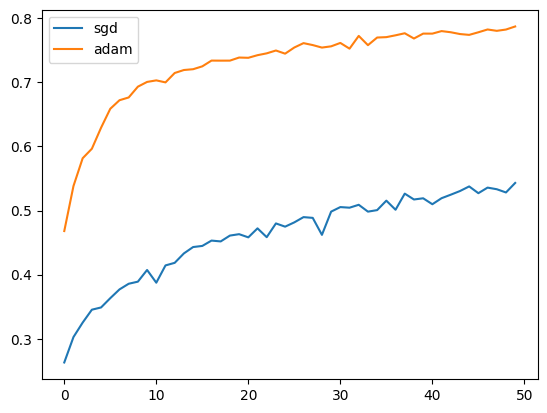

In [12]:
# PLOT1
plot_acc(sgd_train_accuracies, adam_train_accuracies, "sgd", "adam")

In [13]:
# PLOT2
leaky_ReLU_train_accuracies, _ = train_and_validate(
    model_leaky_ReLU_plot2, optimizer_adam_plot2
)
sigmoid_train_accuracies, _ = train_and_validate(model_sigmoid, optimizer_adam_sigmoid)


Epoch   1
            Loss   Accuracy
 Train    129.47    47.44%
Validate  113.58    49.36%

Epoch   2
            Loss   Accuracy
 Train    103.54    55.41%
Validate  100.66    55.55%

Epoch   3
            Loss   Accuracy
 Train     93.12    60.54%
Validate   88.27    61.55%

Epoch   4
            Loss   Accuracy
 Train     86.82    63.04%
Validate   84.25    63.95%

Epoch   5
            Loss   Accuracy
 Train     81.79    64.70%
Validate   77.26    66.01%

Epoch   6
            Loss   Accuracy
 Train     78.48    64.68%
Validate   74.26    67.63%

Epoch   7
            Loss   Accuracy
 Train     76.1     66.24%
Validate   77.33    66.23%

Epoch   8
            Loss   Accuracy
 Train     74.13    67.45%
Validate   69.83    69.44%

Epoch   9
            Loss   Accuracy
 Train     72.12    68.20%
Validate   76.03    66.21%

Epoch  10
            Loss   Accuracy
 Train     70.4     67.15%
Validate   70.73    68.84%

Epoch  11
            Loss   Accuracy
 Train     69.33    68.78%
Vali

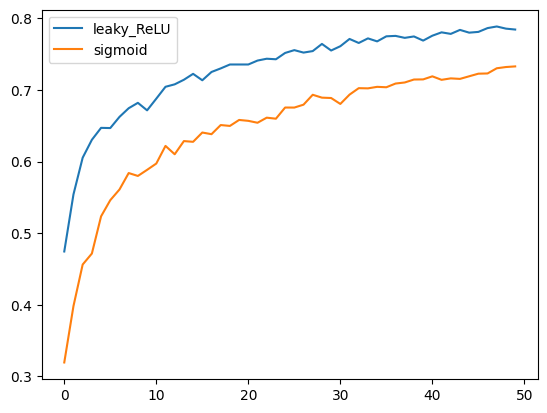

In [14]:
# PLOT2
plot_acc(leaky_ReLU_train_accuracies, sigmoid_train_accuracies, "leaky_ReLU", "sigmoid")

In [15]:
# PLOT3
dropout_train_accuracies, dropout_validate_accuracies = train_and_validate(
    model_leaky_ReLU_dropout, optimizer_dropout
)


Epoch   1
            Loss   Accuracy
 Train    132.23    48.36%
Validate  114.78    47.96%

Epoch   2
            Loss   Accuracy
 Train    105.45    53.30%
Validate  103.07    52.65%

Epoch   3
            Loss   Accuracy
 Train     95.26    59.62%
Validate   89.41    60.77%

Epoch   4
            Loss   Accuracy
 Train     87.62    61.84%
Validate   81.31    64.82%

Epoch   5
            Loss   Accuracy
 Train     83.31    63.26%
Validate   79.38    65.61%

Epoch   6
            Loss   Accuracy
 Train     79.57    65.04%
Validate   77.36    65.83%

Epoch   7
            Loss   Accuracy
 Train     76.44    66.57%
Validate   72.44    68.37%

Epoch   8
            Loss   Accuracy
 Train     74.29    67.47%
Validate   72.98    67.97%

Epoch   9
            Loss   Accuracy
 Train     72.79    67.85%
Validate   72.67    68.46%

Epoch  10
            Loss   Accuracy
 Train     71.05    69.70%
Validate   67.98    70.89%

Epoch  11
            Loss   Accuracy
 Train     69.3     69.94%
Vali

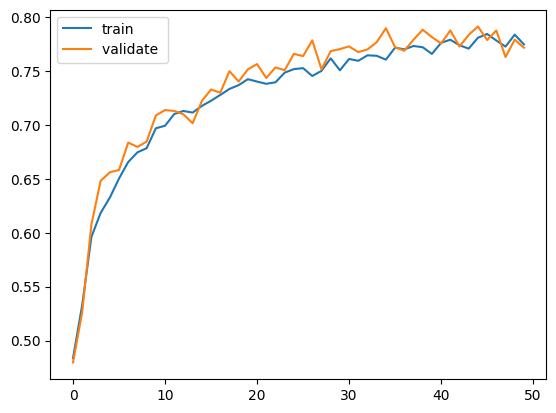

In [16]:
# PLOT3
plot_acc(dropout_train_accuracies, dropout_validate_accuracies, "train", "validate ")